In [88]:
import pandas as pd
import random
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [89]:
# Get S&P 500 tickers
def get_sp500_tickers(sample_size=300):
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url)[0]
    tickers = table['Symbol'].tolist()
    sample_tickers = random.sample(tickers, sample_size)
    return sample_tickers

In [90]:
# Fetch historical data
def get_historical_data(tickers):
    data = pd.DataFrame()
    for i in tickers:
        stock_data = yf.download(i, start="2022-01-01", end="2024-09-10")
        data[i] = stock_data['Adj Close']
    return data

In [91]:
# Perform the ADF test for stationarity
def adf_test(series):
    result = adfuller(series)
    return result[1]  # Return p-val

In [92]:
# Cointegration test between pairs of stocks
def cointegration_test(data):
    pairs = []
    results = []
    
    tickers = data.columns
    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            x = data[tickers[i]].dropna()
            y = data[tickers[j]].dropna()
            
            x, y = x.align(y, join='inner')  # Align x and y by matching labels (dates)
            if x.empty or y.empty:
                continue
            
            try:
                score, p_value, _ = coint(x, y)
            except ValueError:
                continue
            
            ratio = x / y
            adf_p_value = adf_test(ratio)
            
            pairs.append((tickers[i], tickers[j]))
            results.append((tickers[i], tickers[j], score, p_value, adf_p_value))
    
    results_df = pd.DataFrame(results, columns=['Stock 1', 'Stock 2', 'Cointegration Score', 'Cointegration p-value', 'ADF p-value'])
    return results_df

In [93]:
# Calculate z-score for the ratio
def calculate_zscore(ratio):
    mean = ratio.rolling(window=30).mean()
    std = ratio.rolling(window=30).std()
    zscore = (ratio - mean) / std
    return zscore

In [94]:
# Feature engineering: calculate moving averages and z-scores
def generate_features(ratio):
    ratio = ratio.dropna()
    features = pd.DataFrame()
    
    features['30d_ma'] = ratio.rolling(window=30).mean()
    features['5d_ma'] = ratio.rolling(window=5).mean()
    features['z_score'] = calculate_zscore(ratio)
    
    # Drop rows with NaN values after rolling windows
    features.dropna(inplace=True)
    
    return features

In [95]:
# Get S&P 500 tickers and historical data
ticks = get_sp500_tickers()
historical_data = get_historical_data(ticks)

# Cointegration test
results_df = cointegration_test(historical_data)

# Filter pairs with the lowest ADF p-values
filtered_results = results_df[results_df['ADF p-value'] < 0.05]

# Sort pairs by cointegration score to find the most cointegrated pair
sorted_results = filtered_results.sort_values(by='Cointegration Score', ascending=True)

# Get the top cointegrated pair
top_pair = sorted_results.iloc[0]
stock1, stock2 = top_pair['Stock 1'], top_pair['Stock 2']

# Calculate the ratio for the top pair
ratio = historical_data[stock1] / historical_data[stock2]

# Generate features for the ratio
features = generate_features(ratio)

# Define target signals based on z-score thresholds
entry_threshold = 1.5
exit_threshold = 0

features['target'] = np.where(features['z_score'] > entry_threshold, -1,
                              np.where(features['z_score'] < -entry_threshold, 1, 0))

# Split data into train and test sets
X = features[['30d_ma', '5d_ma']]
y = features['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = False)

# Train a Random Forest classifier
model = RandomForestClassifier()
# model = SVC(kernel='rbf', C=1.0)
model.fit(X_train, y_train)

# Predict signals on the test set
y_pred = model.predict(X_test)

print("historica_data:", historical_data.head())
print("results_df:", results_df.head())
print("filtered_results:", filtered_results.head())
print("sorted_results:", sorted_results)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

historica_data:                    PSA        BWA        IVZ        DAL        TROW  \
Date                                                                  
2022-01-03  318.487549  38.222294  20.507177  39.783428  172.683487   
2022-01-04  318.269623  40.548801  21.405300  40.079655  173.162704   
2022-01-05  315.427185  40.582630  20.859381  39.773552  166.382462   
2022-01-06  318.539886  41.200218  21.255611  39.605694  168.636627   
2022-01-07  310.317932  41.132538  21.607821  40.988087  170.021118   

                  AOS        EQIX        GRMN        WDC         SO  ...  \
Date                                                                 ...   
2022-01-03  79.623749  792.597046  124.466087  65.930000  61.264996  ...   
2022-01-04  80.948097  772.234985  124.484741  67.620003  61.264996  ...   
2022-01-05  79.595139  748.033569  124.000114  67.059998  61.336895  ...   
2022-01-06  80.128716  734.743286  123.748497  64.739998  61.264996  ...   
2022-01-07  79.223557  734.610

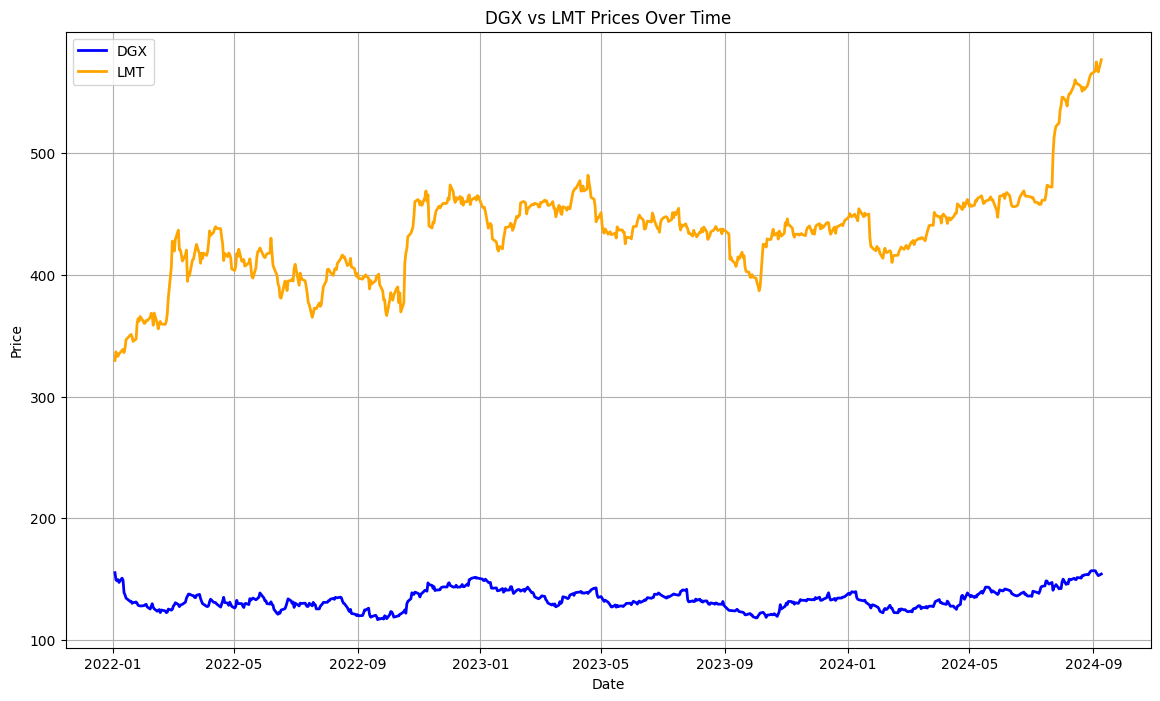

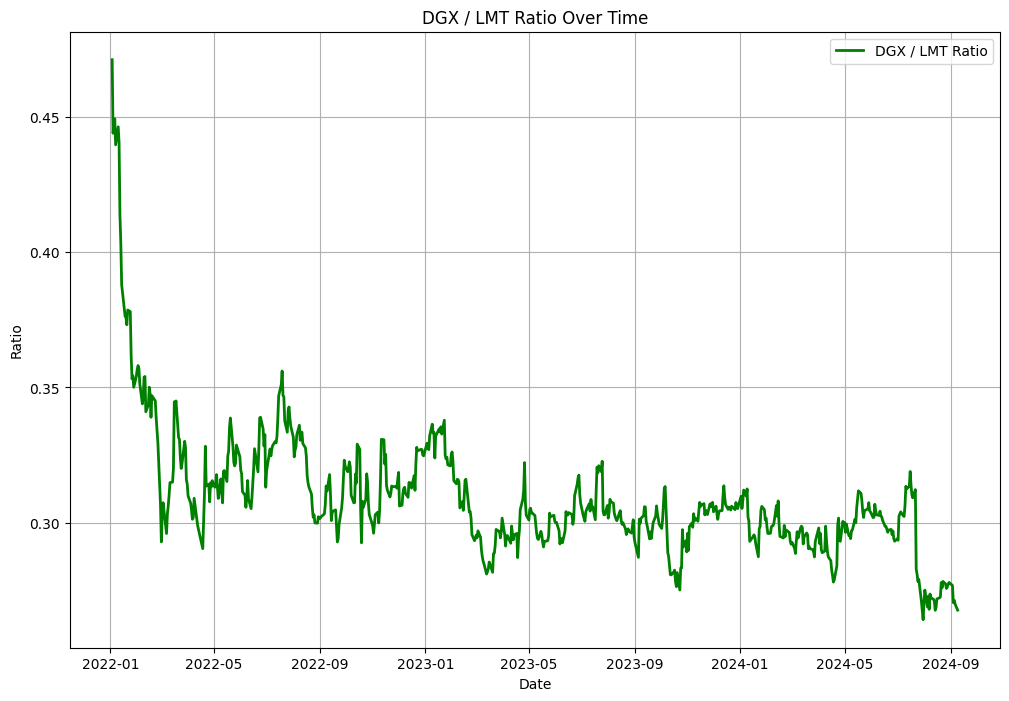

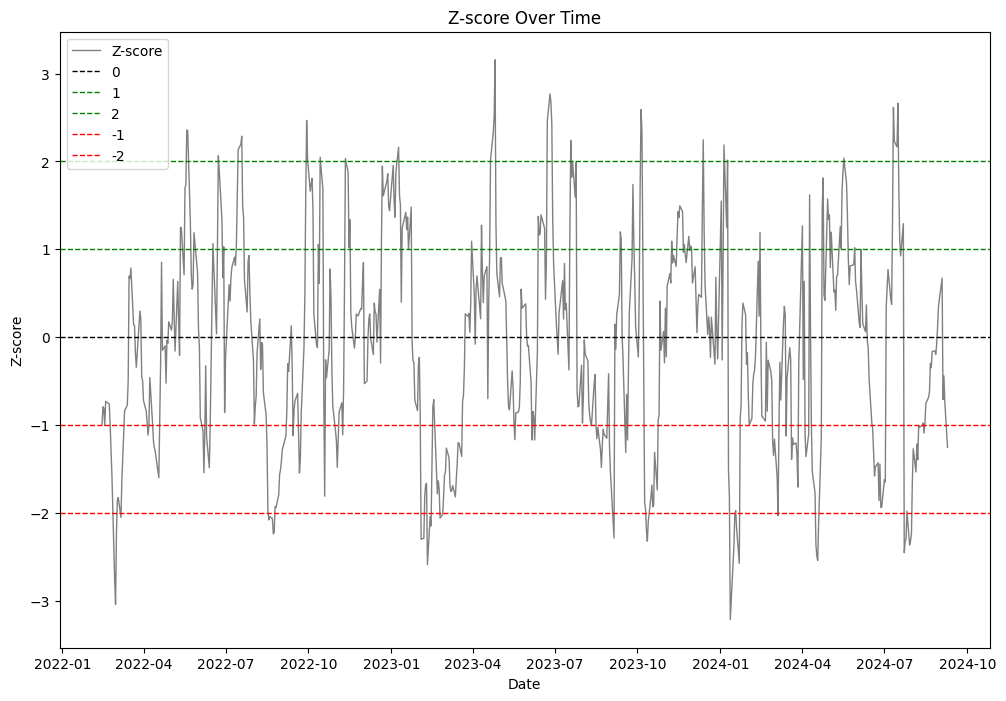

In [109]:
# Plot Stock 1 and Stock 2 Prices
def plot_stocks(stock1, stock2, historical_data):
    plt.figure(figsize=(14, 8))
    
    # Plot stock1 price
    plt.plot(historical_data[stock1], label=stock1, color='blue', linewidth=2)
    
    # Plot stock2 price
    plt.plot(historical_data[stock2], label=stock2, color='orange', linewidth=2)
    
    # Labels and title
    plt.title(f'{stock1} vs {stock2} Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Ratio (Stock 1 / Stock 2)
def plot_ratio(ratio):
    plt.figure(figsize=(12, 8))
    
    # Plot the ratio of Stock 1 to Stock 2
    plt.plot(ratio, label=f'{stock1} / {stock2} Ratio', color='green', linewidth=2)
    
    # Labels and title
    plt.title(f'{stock1} / {stock2} Ratio Over Time')
    plt.xlabel('Date')
    plt.ylabel('Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot z-score
def plot_zscore(zscore):
    plt.figure(figsize=(12, 8))
    plt.plot(zscore, label='Z-score', color='gray', linewidth=1)
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label='0')
    plt.axhline(y=1, color='green', linestyle='--', linewidth=1, label='1')
    plt.axhline(y=2, color='green', linestyle='--', linewidth=1, label='2')
    plt.axhline(y=-1, color='red', linestyle='--', linewidth=1, label='-1')
    plt.axhline(y=-2, color='red', linestyle='--', linewidth=1, label='-2')

    # Labels and title
    plt.title('Z-score Over Time')
    plt.xlabel('Date')
    plt.ylabel('Z-score')
    plt.legend()
    plt.show()

# Call the functions to plot
plot_stocks(stock1, stock2, historical_data)
plot_ratio(ratio)
plot_zscore(features['z_score'])

In [96]:
# Define test period stock prices for the top cointegrated pair
stock1_prices_test = historical_data[stock1][-len(y_test):]
stock2_prices_test = historical_data[stock2][-len(y_test):]

# Backtest using ML signals
def backtest_ml_strategy(stock1_prices, stock2_prices, ml_predictions):
    positions = []
    returns = []
    
    position = None
    entry_stock1_price = None
    entry_stock2_price = None

    for i in range(len(ml_predictions)):
        if ml_predictions[i] == 1 and position is None:
            # Enter long (Long Stock 1, Short Stock 2)
            entry_stock1_price = stock1_prices.iloc[i]
            entry_stock2_price = stock2_prices.iloc[i]
            position = 'long'
            positions.append(('long', i))

        elif ml_predictions[i] == -1 and position is None:
            # Enter short (Short Stock 1, Long Stock 2)
            entry_stock1_price = stock1_prices.iloc[i]
            entry_stock2_price = stock2_prices.iloc[i]
            position = 'short'
            positions.append(('short', i))

        # Exit on model prediction or if zscore comes close to 0 (another exit rule)
        elif (ml_predictions[i] == 0 or abs(features['z_score'].iloc[i]) < 0.1) and position is not None:
            # Exit position
            exit_stock1_price = stock1_prices.iloc[i]
            exit_stock2_price = stock2_prices.iloc[i]
            
            if position == 'long':
                # Return for a long position
                returns.append(((exit_stock1_price - entry_stock1_price) / entry_stock1_price) + 
                               ((entry_stock2_price - exit_stock2_price) / entry_stock2_price))
            elif position == 'short':
                # Return for a short position
                returns.append(((entry_stock1_price - exit_stock1_price) / entry_stock1_price) - 
                               ((exit_stock2_price - entry_stock2_price) / entry_stock2_price))
            
            # Record the exit position
            positions.append(('exit', i))
            position = None  # Reset position to none

    return positions, returns

# Call the backtest function with appropriate inputs
positions, returns = backtest_ml_strategy(stock1_prices_test, stock2_prices_test, y_pred)

# Converting returns to a pandas Series
returns = pd.Series(returns)

# Calculating risk-free rate
risk_free_rate = 0.02  # Assuming a 2% annual risk-free rate
daily_risk_free_rate = (1 + risk_free_rate) ** (1 / 252) - 1  # Adjusted for daily returns

# Excess returns (returns - daily risk-free rate)
excess_returns = returns - daily_risk_free_rate

# Mean of excess returns
mean_excess_return = excess_returns.mean()

# Standard deviation of returns (volatility)
volatility = returns.std()

sharpe_ratio = mean_excess_return / volatility

# Print positions and returns
print("Positions:", positions)
print("Returns:", returns)
print("Total return:", sum(returns))
print(f"Sharpe Ratio: {sharpe_ratio}")

Positions: [('long', 0), ('exit', 2), ('short', 37), ('exit', 39), ('short', 40), ('exit', 41), ('short', 42), ('exit', 43), ('short', 48), ('exit', 49), ('short', 50), ('exit', 51), ('short', 52), ('exit', 53), ('short', 54), ('exit', 57), ('long', 76), ('exit', 78), ('long', 80), ('exit', 81), ('long', 98), ('exit', 104)]
Returns: 0     0.003859
1     0.026426
2    -0.004843
3    -0.018012
4    -0.005006
5    -0.016358
6     0.003124
7     0.044704
8    -0.004933
9    -0.001696
10   -0.037841
dtype: float64
Total return: -0.010575546463716824
Sharpe Ratio: -0.04741535187680008


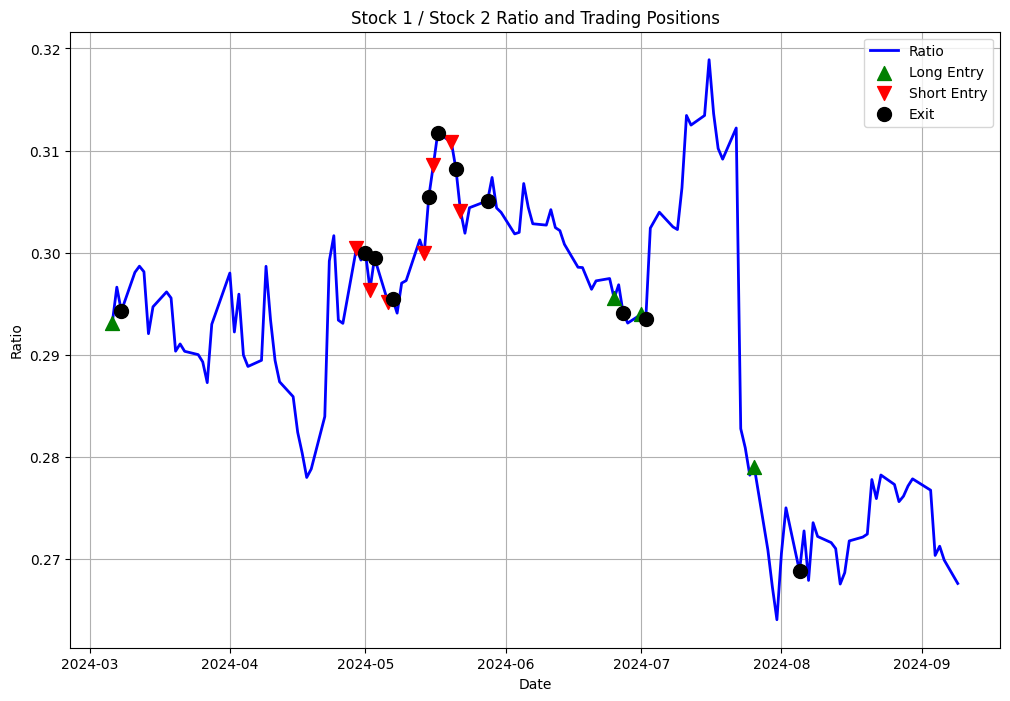

In [98]:
# Plotting function for the ratio and positions
def plot_ratio_with_positions(ratio, positions):
    plt.figure(figsize=(12, 8))
    
    # Plot the ratio as a line graph
    plt.plot(ratio.index, ratio, label="Ratio", color='blue', linewidth=2)
    
    # Separate the position types (long, short, and exit)
    long_positions = [i for pos, i in positions if pos == 'long']
    short_positions = [i for pos, i in positions if pos == 'short']
    exit_positions = [i for pos, i in positions if pos == 'exit']
    
    # Plot long positions as green dots (triangle up)
    plt.scatter(ratio.index[long_positions], ratio.iloc[long_positions], color='green', marker='^', label='Long Entry', s=100, zorder=5)
    
    # Plot short positions as red dots (triangle down)
    plt.scatter(ratio.index[short_positions], ratio.iloc[short_positions], color='red', marker='v', label='Short Entry', s=100, zorder=5)
    
    # Plot exit positions as black dots (circle)
    plt.scatter(ratio.index[exit_positions], ratio.iloc[exit_positions], color='black', marker='o', label='Exit', s=100, zorder=5)
    
    # Adding labels and title
    plt.title(f"Stock 1 / Stock 2 Ratio and Trading Positions")
    plt.xlabel("Date")
    plt.ylabel("Ratio")
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Call the plot function with the ratio and positions from the backtest
plot_ratio_with_positions(ratio[-len(y_test):], positions)